<a href="https://colab.research.google.com/github/shashankcuber/mRNA_Vacc_Stabilization/blob/main/mRNA_vaccine_stabilizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount dataset and rna tools from Drive

In [2]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
open_vaccine_test_data_path = '/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/test_data.csv'

# Installing RNA tools

In [4]:
!cd drive/MyDrive/Bio_informatics_Project/; sh install.sh -Uq

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,060 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,320 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal 

Fix these changes if you download the contrafold source code directly from http://contra.stanford.edu/contrafold/download.html


1.   LBFGS.ipp :  At line 110 write this->DoLineSearch
2.   Utilities.cpp:  Add #include"climits" for ULONG used in this file



# Setting up the arnie conf file and environment variable

In [5]:
import os
os.environ["DATAPATH"] = "/content/RNAstructure/data_tables"
os.environ["ARNIEFILE"] = "/content/arnie.conf"
!cd drive/MyDrive/Bio_informatics_Project/; sh make_arnie_conf.sh

/content
/content/arnie.conf
/content/RNAstructure/data_tables
TMP: /content/tmp
rnastructure: /content/RNAstructure/exe
contrafold_2: /content/contrafold-se/src
vienna_2: /usr/bin


# Importing Libraries For Test Data

In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
from arnie.bpps import bpps
import arnie.utils as utils
from arnie.mea.mea import MEA

# Test data replication using rna tools

In [7]:
class PrepareTestDataset:
  def __init__(self, rna_tool, path):
    self.package = rna_tool
    self.path = path
    self.df = pd.read_csv(path)


  def _predict_structure(self, id, rna_sequence):
    base_pairing_mat = bpps(rna_sequence, package = self.package)
    secondary_struct = MEA(base_pairing_mat)
    return id, rna_sequence, secondary_struct.structure, self.package
  
  def make_dataset(self):
    temp_df = self.df[['id','sequence']]
    
    dataset = []

    for j,(id,seq) in enumerate(tqdm(temp_df[['id', 'sequence']].values)):
      data = self._predict_structure(id, seq)
      dataset.append(data)

    df = pd.DataFrame(dataset, columns = ['id', 'sequence', 'structure','package'])
    df['seq_length'] = df['id'].map(self.df.drop_duplicates().set_index('id')['seq_length'])
    df['seq_scored'] = df['id'].map(self.df.drop_duplicates().set_index('id')['seq_scored'])
    return df

In [8]:
#vienna_2
vienna = PrepareTestDataset('vienna_2', open_vaccine_test_data_path)
vienna_df = vienna.make_dataset()
vienna_df.head()

100%|██████████| 600/600 [04:44<00:00,  2.11it/s]


,id,sequence,structure,package,seq_length,seq_scored
0,id_3b7827fb0,GGAAACGUCUGUAGCUGAGUGCUACAGACGAAUAGGUAGACAGCUG...,.....((((((((((.....))))))))))....(((((((((((....,vienna_2,130,91
1,id_f5212dd4e,GGAAAGUGCUACGCUGUACCGUGAGGUACAGCCGACGGUACGUCGG...,.....(((((((.(((((((....)))))))((((((...))))))...,vienna_2,130,91
2,id_0d6a71f64,GGAAAGCGAAUCGACGAGAAGUCGUAGUUCGCAGAGCGGCGUACCC...,.....((((((((((.....))))..))))))...((((((((......,vienna_2,130,91
3,id_6e072995a,GGAAACAAGCACACACUCUGCAGGCACAAAGGUGUAGUAGUUGUAU...,........((((((((((((((((((((..((((((((.(((((((...,vienna_2,130,91
4,id_5ccbcb6ff,GGAAAGUCUAGACGAACUAACUAGGACAUCCCUAGGUGAAGUACCA...,.....((((..(((......(((((.....)))))((((.((.......,vienna_2,130,91


In [9]:
# #contrafold_2
# contrafold = PrepareTestDataset('contrafold_2', open_vaccine_test_data_path)
# contrafold_df = contrafold.make_dataset()
# contrafold_df.head()

In [10]:
#rnastructure
# rnastructure = PrepareTestDataset('rnastructure', open_vaccine_test_data_path)
# rnastructure_df = rnastructure.make_dataset()
# rnastructure_df.head()

# Importing Libraries for Model Pipeline

In [11]:
"""
Importing the necessary libraries
"""
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.modules.loss import MSELoss
from sklearn.model_selection import train_test_split, KFold
torch.backends.cudnn.deterministic = True

import random

# To ensure the random function generates the same random values on different runs
random.seed(hash("setting random seeds") % 2023)
np.random.seed(hash("improves reproducibility") % 2023)
torch.manual_seed(hash("by removing stochasticity") % 2023)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2023)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
token_int_dict = {
        '(' : 0,
        ')' : 1,
        '.' : 2,
        'A' : 3,
        'G' : 4,
        'C' : 5,
        'U' : 6,
    }
WB_API_KEY = "cddbb81e657d85514600791c422ff35c68117a53"

In [12]:
"""
Insatalling Weights and Biases wandb to track the Model evaluation
and login to wandb
"""
!pip install wandb -Uq
!wandb login --relogin
import wandb
# wandb.login(key = WB_API_KEY) 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.1 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# EDA Train Data

In [13]:
"""
LOADING THE TRAIN DATA
"""
open_vaccine_train_data_path = '/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/train.json'
train_df = pd.read_json(open_vaccine_train_data_path, lines=True)
train_df = train_df.drop(columns=['index'])
train_df.head(3)

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."


In [14]:
class DataPreprocessing:
  def __init__(self, data, device, token_int_dict, feature_columns = ["sequence", "structure"], 
               train_data = True, labels = None):
    self.df = data
    self.feature_columns = feature_columns
    self.labels = labels
    self.token_int_dict = token_int_dict
    self.device = device
    self.is_train = train_data

  def num_missing_val(self):
    return self.df.isnull().values.sum()

  def sn_filtering(self):
    self.df = self.df[self.df.SN_filter == 1]

  def tokenize_sequence(self,sequence):
    tokenized_sequence = []
    for char in sequence:
      tokenized_sequence.append(self.token_int_dict[char])
    return tokenized_sequence

  def convert_df_to_array(self, df):
    return np.transpose(np.array(df.values.tolist()), (0,2,1))

  def process_data(self):
    #check if any missing values
    if self.num_missing_val() > 0 and self.is_train:
      self.sn_filtering()
      print(f"Number of missing values in the dataset are:{self.num_missing_val()}")
    elif self.is_train:
      self.sn_filtering()
      print("No Missing Values")
    
    feature_df = self.df[self.feature_columns].applymap(lambda sequence: self.tokenize_sequence(sequence))
    feature_tensor =  torch.tensor(self.convert_df_to_array(feature_df)).to(self.device)

    if self.is_train:
      label_tensor = torch.tensor(self.convert_df_to_array(self.df[self.labels])).float().to(device)
      return feature_tensor, label_tensor
  
    return feature_tensor

In [15]:
labels = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
train_process = DataPreprocessing(train_df, device, token_int_dict,  labels = labels)
x_train, y_train = train_process.process_data()
print(x_train.shape)
print(y_train.shape)

No Missing Values
torch.Size([1589, 107, 2])
torch.Size([1589, 68, 5])


In [16]:
vienna_df_public = vienna_df.query("seq_length == 107").copy()
vienna_df_private = vienna_df.query("seq_length == 130").copy()
test_process_public = DataPreprocessing(vienna_df_public, device, token_int_dict, train_data = False)
vienna_public_tensor = test_process_public.process_data()
test_process_private = DataPreprocessing(vienna_df_private, device, token_int_dict, train_data = False)
vienna_private_tensor = test_process_private.process_data()
print(vienna_public_tensor.shape)
print(vienna_private_tensor.shape)

torch.Size([300, 107, 2])
torch.Size([300, 130, 2])


# MCRMSE LOSS
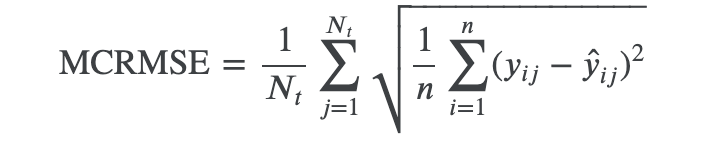

In [17]:
class MeanColumnwiseRMSE(nn.Module):
  def __init__(self, N_t):
    super().__init__()
    self.loss = nn.MSELoss()
    self.nt = N_t
  
  def forward(self, predicted , actual):
    total_loss = 0

    for j in range(self.nt):
        total_loss += torch.sqrt(self.loss(predicted[:, :, j], actual[:, :, j]))

    total_loss /= self.nt
    return total_loss

# Defining configuration for model and training

# bi-GRU Model

In [18]:
class bi_GRU(nn.Module):
  def __init__(self, config, public_data = False, private_data = False):
    super(bi_GRU, self).__init__()
    if(public_data):
      self.prediction_len = 68
      self.squence_len = 107
    elif private_data:
      self.prediction_len = 91
      self.squence_len = 130

    self.token_int_len = len(token_int_dict)
    self.embedding_layer = nn.Embedding(num_embeddings = self.token_int_len, embedding_dim = config.embedding_dim)
    self.bi_gru = nn.GRU(
        input_size = config.gru_input_size,
        hidden_size = config.gru_hidden_size,
        num_layers = config.gru_num_layers, # hidden_layers
        batch_first = True,
        dropout = config.gru_dropout_rate,
        bidirectional = True)
    self.l1 = nn.Linear(config.gru_hidden_size * 2, len(labels))
  
  def reshape_embedding(self, embedding):
      x , y , z = embedding.shape[1] , embedding.shape[2], embedding.shape[3]
      return torch.reshape(embedding, (-1, x, y * z))
      
  def forward(self, sequence):
    embedding = self.embedding_layer(sequence)
    embed_reshape = self.reshape_embedding(embedding)
    output,h_n = self.bi_gru(embed_reshape)
    slice_output = output[:, : self.prediction_len, :]
    final_output = self.l1(slice_output)
    return final_output

# Train Step

In [19]:
class Train:
  def __init__(self, x_train, y_train, model, loss_criterion, optimizer, training=True):
    self.x_train = x_train
    self.labels = y_train
    self.model = model
    self.loss_criterion = loss_criterion
    self.optimizer = optimizer
    self.training = training

  def train_step(self):
    wandb.watch(model, criterion, log="all", log_freq=10)
    # forward propogation
    self.model.train(self.training)
    output = self.model(self.x_train)
    loss = self.loss_criterion.forward(output, self.labels)
    #backward propogation
    if self.training:
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    return loss.item()

#Training bi-GRU Model

In [22]:
train_config = dict(
    k_fold=3,
    epochs=90,
    batch_size=64,
    learning_rate=0.01,
    embedding_dim=200,
    gru_input_size=200 * 2,
    gru_hidden_size=128,
    gru_num_layers=3,
    gru_dropout_rate=0.5)

run = wandb.init(project="mRNA-Stabilization-test-1", config = train_config)
train_config = wandb.config
gru_history = []
criterion = MeanColumnwiseRMSE(5)
kfold = KFold(train_config.k_fold, shuffle=True, random_state=2023)
for k, (train_index, val_index) in enumerate(kfold.split(x_train)):
    train_dataset = TensorDataset(x_train[train_index], y_train[train_index])
    val_dataset = TensorDataset(x_train[val_index], y_train[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_config.batch_size)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=train_config.batch_size)

    model = bi_GRU(train_config, public_data=True).to(device)
    optimizer = optim.Adam(model.parameters(), lr=train_config.learning_rate)

    train_losses = []
    val_losses = []
    run = wandb.init(reinit = True, project="mRNA-Stabilization-test-1", config = train_config)
    for epoch in tqdm(range(train_config.epochs)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            training = Train(batch_X, batch_Y, model, criterion, optimizer, training=True)
            train_loss = training.train_step()
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            validation = Train(batch_X, batch_Y, model, criterion, optimizer, training=False)
            val_loss = validation.train_step()
            val_losses_batch.append(val_loss)
        train_losses.append(np.mean(train_losses_batch))
        val_losses.append(np.mean(val_losses_batch))
        wandb.log({
            "epoch": epoch, 
            "train_loss": np.mean(train_losses_batch), 
            "val_loss": np.mean(val_losses_batch)
            })
        print(f" At EPOCH = {epoch} , TRAINING LOSS = {np.mean(train_losses_batch)} , VALIDATION LOSS = {np.mean(train_losses_batch)}")
    run.finish()
    model_state = model.state_dict()
    del model
    gru_history.append({'train_loss': train_losses, 'val_loss': val_losses})

  0%|          | 0/90 [00:00<?, ?it/s]

 At EPOCH = 0 , TRAINING LOSS = 0.8316220325582168 , VALIDATION LOSS = 0.8316220325582168
 At EPOCH = 1 , TRAINING LOSS = 0.4431352948441225 , VALIDATION LOSS = 0.4431352948441225
 At EPOCH = 2 , TRAINING LOSS = 0.41354811542174397 , VALIDATION LOSS = 0.41354811542174397
 At EPOCH = 3 , TRAINING LOSS = 0.401736773112241 , VALIDATION LOSS = 0.401736773112241
 At EPOCH = 4 , TRAINING LOSS = 0.39348575297523947 , VALIDATION LOSS = 0.39348575297523947
 At EPOCH = 5 , TRAINING LOSS = 0.39124401702600364 , VALIDATION LOSS = 0.39124401702600364
 At EPOCH = 6 , TRAINING LOSS = 0.3766436524250928 , VALIDATION LOSS = 0.3766436524250928
 At EPOCH = 7 , TRAINING LOSS = 0.3837704518262078 , VALIDATION LOSS = 0.3837704518262078
 At EPOCH = 8 , TRAINING LOSS = 0.3745202053995693 , VALIDATION LOSS = 0.3745202053995693
 At EPOCH = 9 , TRAINING LOSS = 0.3689582821200876 , VALIDATION LOSS = 0.3689582821200876
 At EPOCH = 10 , TRAINING LOSS = 0.36989864531685324 , VALIDATION LOSS = 0.36989864531685324
 At

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▃▁▃▂▂▁▃▁▂▁▂▁▂▂▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▂▂▁
epoch,89
train_loss,0.34132
val_loss,0.34969


  0%|          | 0/90 [00:00<?, ?it/s]

 At EPOCH = 0 , TRAINING LOSS = 0.8276904593495762 , VALIDATION LOSS = 0.8276904593495762
 At EPOCH = 1 , TRAINING LOSS = 0.4535030792741215 , VALIDATION LOSS = 0.4535030792741215
 At EPOCH = 2 , TRAINING LOSS = 0.422650347737705 , VALIDATION LOSS = 0.422650347737705
 At EPOCH = 3 , TRAINING LOSS = 0.40811752922394695 , VALIDATION LOSS = 0.40811752922394695
 At EPOCH = 4 , TRAINING LOSS = 0.40133444526616263 , VALIDATION LOSS = 0.40133444526616263
 At EPOCH = 5 , TRAINING LOSS = 0.3957909503403832 , VALIDATION LOSS = 0.3957909503403832
 At EPOCH = 6 , TRAINING LOSS = 0.3910011070616105 , VALIDATION LOSS = 0.3910011070616105
 At EPOCH = 7 , TRAINING LOSS = 0.3844022610608269 , VALIDATION LOSS = 0.3844022610608269
 At EPOCH = 8 , TRAINING LOSS = 0.38220276376780343 , VALIDATION LOSS = 0.38220276376780343
 At EPOCH = 9 , TRAINING LOSS = 0.38468539539505453 , VALIDATION LOSS = 0.38468539539505453
 At EPOCH = 10 , TRAINING LOSS = 0.3734004532589632 , VALIDATION LOSS = 0.3734004532589632
 At

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▃▂▂▂▂▂▁▁▃▂▁▁▂▁▁▂▂▁▂▁▁▂▂▁▁▂▂▁▂▁▁▁
epoch,89
train_loss,0.34531
val_loss,0.33211


  0%|          | 0/90 [00:00<?, ?it/s]

 At EPOCH = 0 , TRAINING LOSS = 0.7036960545708152 , VALIDATION LOSS = 0.7036960545708152
 At EPOCH = 1 , TRAINING LOSS = 0.44332359818851247 , VALIDATION LOSS = 0.44332359818851247
 At EPOCH = 2 , TRAINING LOSS = 0.42325926352949705 , VALIDATION LOSS = 0.42325926352949705
 At EPOCH = 3 , TRAINING LOSS = 0.40519991166451397 , VALIDATION LOSS = 0.40519991166451397
 At EPOCH = 4 , TRAINING LOSS = 0.39728106470669017 , VALIDATION LOSS = 0.39728106470669017
 At EPOCH = 5 , TRAINING LOSS = 0.3974790573120117 , VALIDATION LOSS = 0.3974790573120117
 At EPOCH = 6 , TRAINING LOSS = 0.3893747101811802 , VALIDATION LOSS = 0.3893747101811802
 At EPOCH = 7 , TRAINING LOSS = 0.38313549231080446 , VALIDATION LOSS = 0.38313549231080446
 At EPOCH = 8 , TRAINING LOSS = 0.40005644104060006 , VALIDATION LOSS = 0.40005644104060006
 At EPOCH = 9 , TRAINING LOSS = 0.42981522223528695 , VALIDATION LOSS = 0.42981522223528695
 At EPOCH = 10 , TRAINING LOSS = 0.397460153874229 , VALIDATION LOSS = 0.3974601538742

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▅▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▁▁▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁
epoch,89
train_loss,0.35368
val_loss,0.34505


Text(0.5, 0, 'Epoch')

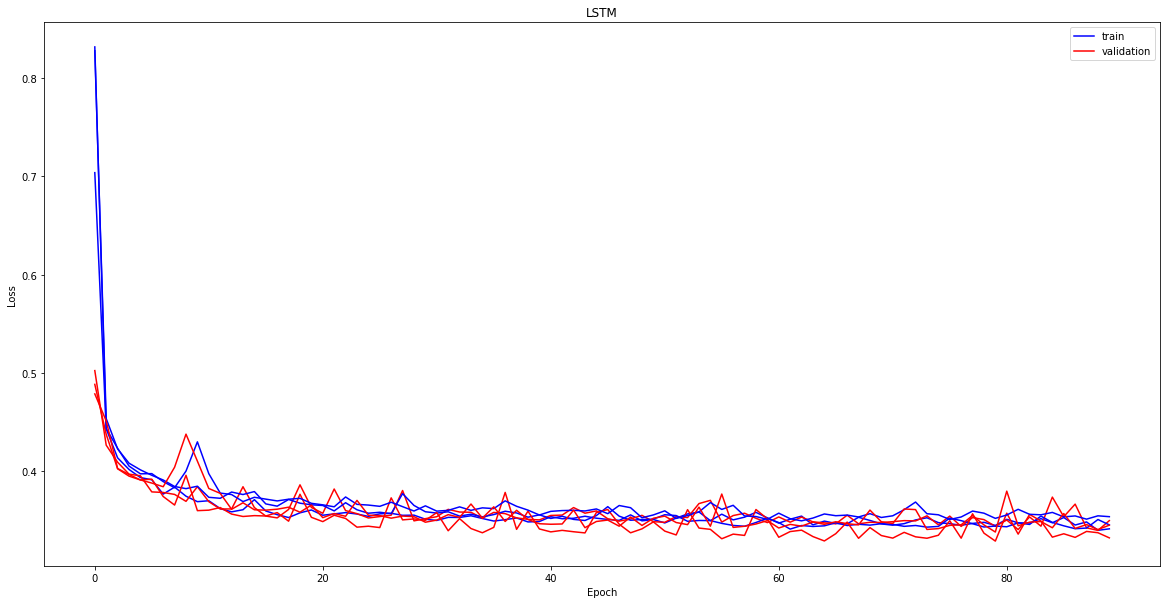

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

for history in gru_history:
    ax.plot(history['train_loss'], 'b')
    ax.plot(history['val_loss'], 'r')

ax.set_title('LSTM')

ax.legend(['train', 'validation'], loc = 'upper right')

ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')